In [1]:
%load_ext autoreload
%autoreload 2

# Deep Gaussian Markov Random Fields on lattice (the original DGMRFs on images)

Original code can be found [here](https://bitbucket.org/psiden/deepgmrf/src/master/main_script.py). And the article is [here](http://proceedings.mlr.press/v119/siden20a/siden20a.pdf).

In [2]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]=""

from functools import partial
from torch.distributions import MultivariateNormal
import torch
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import optax
from jax_tqdm import scan_tqdm
import copy
import equinox as eqx
import numpy as np


key = jax.random.PRNGKey(0)

In [3]:
try:
    gpu_device = jax.devices('gpu')[0]
    cpu_device = jax.devices('cpu')[0]
    print(cpu_device, gpu_device)
except:
    cpu_device = jax.devices('cpu')[0]
    print(cpu_device)

TFRT_CPU_0 cuda:0


## First create some observations
We sample a GMRF with Cholesky sampling

In [4]:
H = 30
W = 30
r = 5

In [5]:
from dgmrf.utils import cholesky_sampling_gaussian_field
key, subkey = jax.random.split(key)
source_term = jax.random.normal(subkey, shape=(H * W,))

with jax.default_device(cpu_device):
    x_ori = cholesky_sampling_gaussian_field(r, source_term.flatten(), H, W)

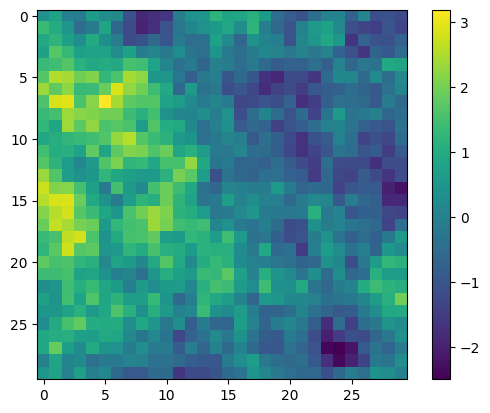

In [6]:
plt.imshow(x_ori)
plt.colorbar()
plt.show()

Add noise over the observations

In [7]:
key, subkey = jax.random.split(key)
true_sigma_noise = 0.4
y = x_ori + jax.random.normal(subkey, x_ori.shape) * true_sigma_noise
M = H * W # no pixel are hidden in the observations
N = H * W

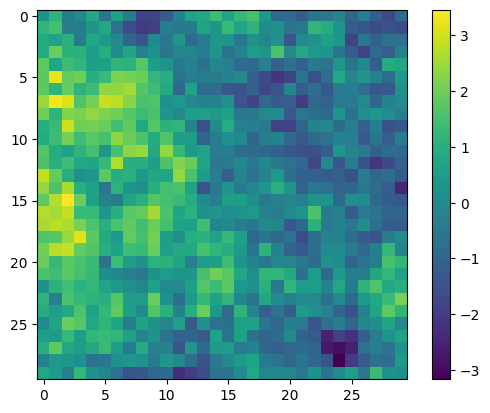

In [8]:
plt.imshow(y)
plt.colorbar()
plt.show()

## Define the DGMRF components

In [9]:
from dgmrf.models import DGMRF
from dgmrf.utils import get_adjacency_matrix_lattice

In [10]:
L = 3
Nq = 10

In [11]:
y = y.flatten()

In [12]:
key, subkey = jax.random.split(key, 2)

dgmrf = DGMRF(subkey, L, height_width=(H, W))

dgmrf_params, dgmrf_static = eqx.partition(dgmrf, lambda x:eqx.is_inexact_array(x)) # and not eqx.is_exact because the layer would consider self.key as a parameter!

## Variational inference to compute model parameters

The initial values of the mean and std for the variational distribution are given lines 572 and 573 of the orignal code.

In [13]:
key, subkey1, subkey2 = jax.random.split(key, 3)
params_init = {
    "dgmrf":dgmrf_params,
    "log_sigma":jnp.log(true_sigma_noise),
    "nu_phi":y, #jnp.ones((H * W,)) * jax.random.uniform(subkey1, (H*W,), minval=-3, maxval=3), # * 0.3,
    "log_S_phi":jax.nn.softplus(jax.random.normal(subkey2, (N,)) * 0.01), # jnp.ones((H * W,)) * 1
}
static = {
    "dgmrf": dgmrf_static
}


In [14]:
n_iter = 1000
lr_conv = 1e-3

lr = lr_conv
tx = optax.multi_transform(
    {
     'dgmrf': optax.adam(lr), 'log_sigma': optax.adam(0),
     'nu_phi': optax.adam(lr), 'log_S_phi': optax.adam(lr)},
    {'dgmrf':"dgmrf", 'log_sigma':'log_sigma', 'nu_phi':'nu_phi', 'log_S_phi':'log_S_phi'} # This what would be returned by the label_fn; i.e. this is the correct syntax when directly giving labels and when params is dict
)
opt_state = tx.init(params_init)

In [15]:
dgmrf = eqx.combine(params_init["dgmrf"], static["dgmrf"])

In [16]:
from dgmrf.losses import dgmrf_elbo
from dgmrf.train import train_loop

key, subkey = jax.random.split(key, 2)
params_final, loss_val = train_loop(dgmrf_elbo, y, n_iter, params_init, static, tx, opt_state, subkey, N, Nq, M)

  0%|          | 0/1000 [00:00<?, ?it/s]

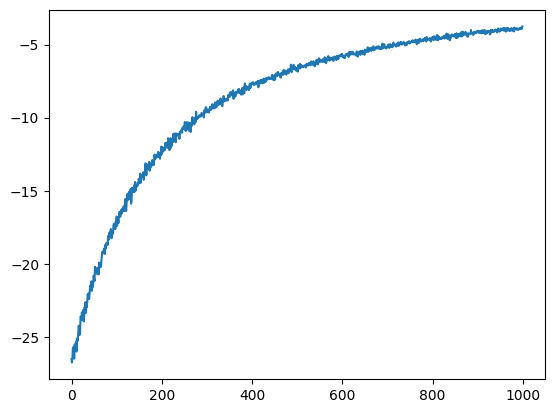

In [17]:
plt.plot(-loss_val)
plt.show()

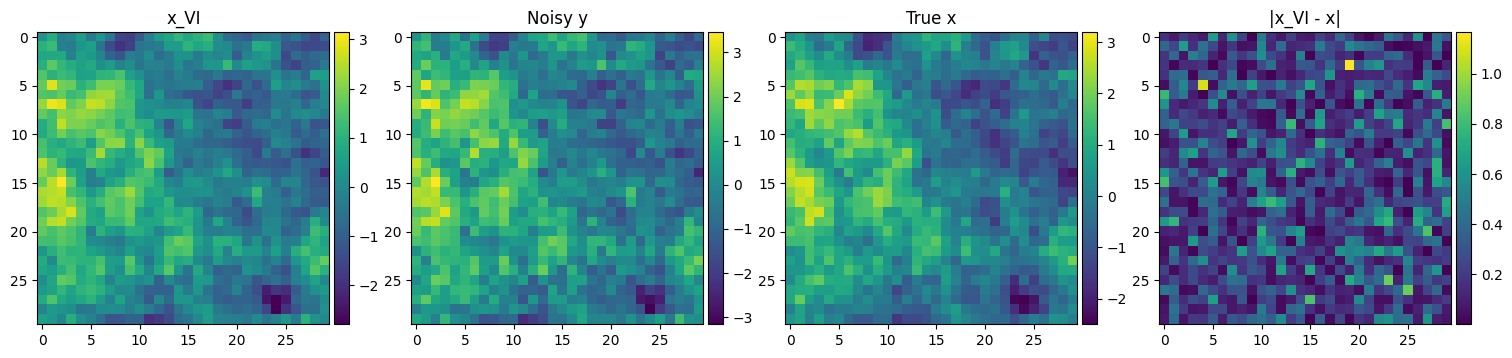

In [18]:
fig, axes = plt.subplots(1, 4)
fig.set_size_inches(18.5, 10.5)

im = axes[0].imshow(params_final["nu_phi"].reshape(H, W))
axes[0].set_title("x_VI")
divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axes[1].imshow(y.reshape(H, W))
axes[1].set_title("Noisy y")
divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axes[2].imshow(x_ori)
axes[2].set_title("True x")
divider = make_axes_locatable(axes[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axes[3].imshow(jnp.abs(params_final["nu_phi"].reshape(H, W) - x_ori))
divider = make_axes_locatable(axes[3])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axes[3].set_title("|x_VI - x|")

plt.show()

## Posterior mean computation with conjugate gradient

In [19]:
dgmrf = eqx.combine(params_final["dgmrf"], static["dgmrf"])

In [20]:
xpost_mean = dgmrf.get_post_mu(y, params_final["log_sigma"], params_final["nu_phi"])

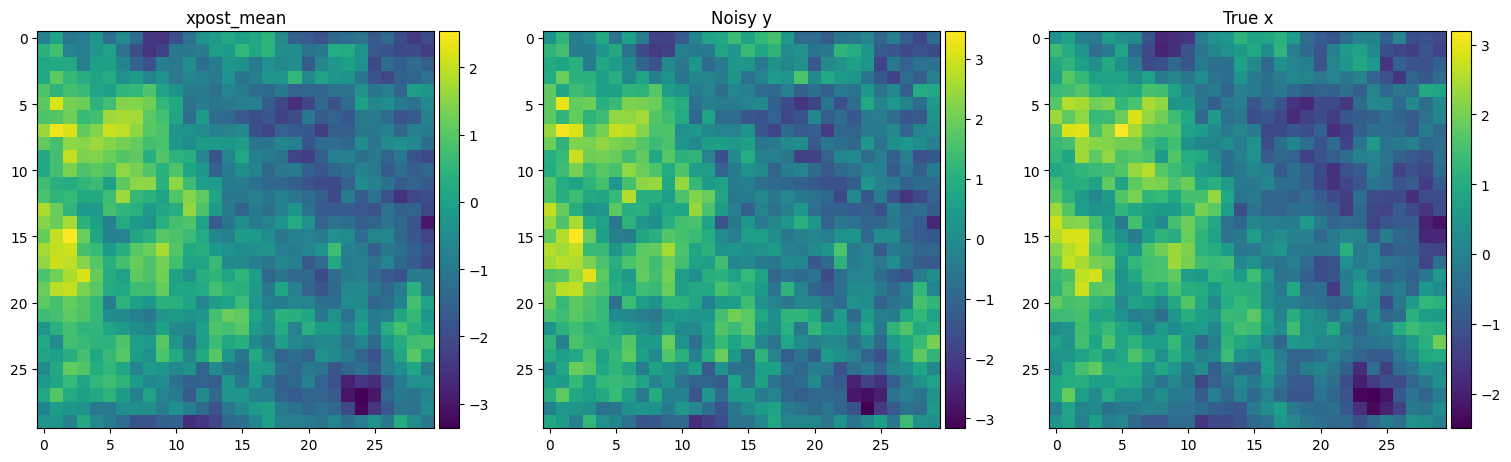

In [21]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(18.5, 10.5)

im = axes[0].imshow(xpost_mean.reshape(H, W))
axes[0].set_title("xpost_mean")
divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axes[1].imshow(y.reshape(H, W))
axes[1].set_title("Noisy y")
divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axes[2].imshow(x_ori)
axes[2].set_title("True x")
divider = make_axes_locatable(axes[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

plt.show()

## Posterior samples to compute the posterior marginal variances

In [22]:
nb_samples = 50

dgmrf = eqx.combine(params_final["dgmrf"], static["dgmrf"])

key, subkey = jax.random.split(key, 2)
x_post_samples = dgmrf.posterior_samples(nb_samples, y, params_final["log_sigma"], subkey, x0=xpost_mean)

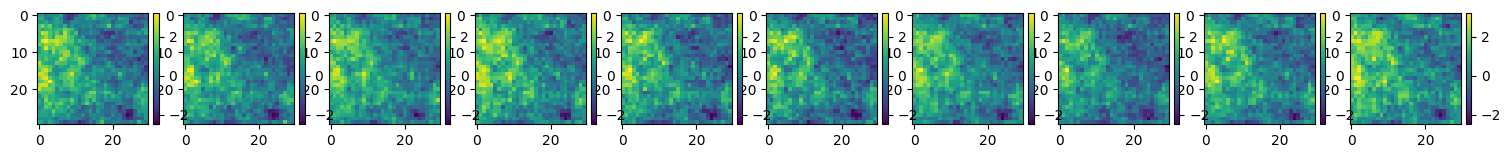

In [23]:
fig, axes = plt.subplots(1, 10)
fig.set_size_inches(18.5, 10.5)

for i, ax in enumerate(axes):
    ax.imshow(x_post_samples[i].reshape(H, W))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

### Simple MC estimator

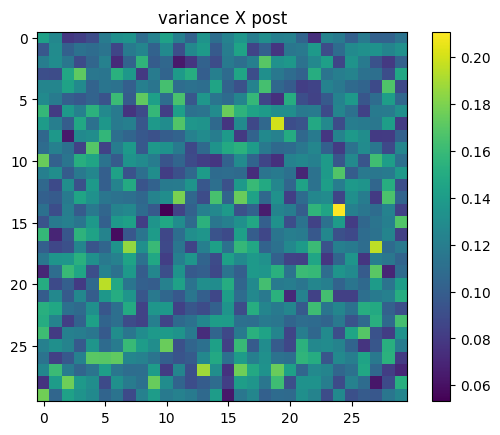

In [24]:
var_x_post_samples = jnp.var(x_post_samples, axis=0)
plt.imshow(var_x_post_samples.reshape(H, W))
plt.title("variance X post")
plt.colorbar()
plt.show()

### Simple Rao-Blackwellized Monte Carlo

In [25]:
var_x_post_samples_RBMC = dgmrf.rbmc_variance(x_post_samples, params_final["log_sigma"])

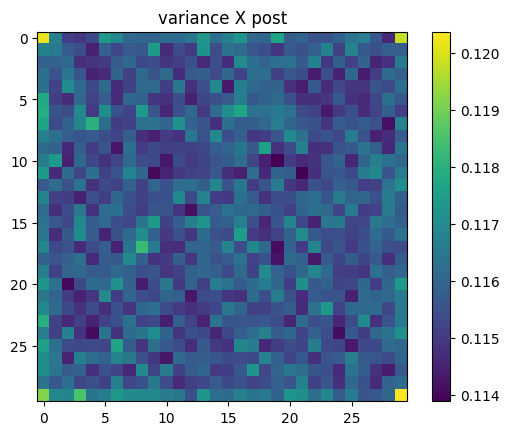

In [26]:
plt.imshow(var_x_post_samples_RBMC.reshape(H, W))
plt.title("variance X post")
plt.colorbar()
plt.show()